In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
import plotly.graph_objects as go

from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [68]:
def get_data(ticker):

    end = datetime.today()
    start = end - relativedelta(years=1)
    
    data = pdr.DataReader(ticker, 'yahoo', start, end)
    data = data.reset_index()
    return data

In [ ]:
def boll_plot(ticker, n=20, m=2):  
    
    data = get_data(ticker)
    
    TP = pd.DataFrame(np.mean([data['High'], data['Low'], data['Close']], axis=0), columns=['Values'])
    
    MA = TP.rolling(n).mean()
    BOLU = TP.rolling(n).mean() + m*TP.rolling(n).std()
    BOLD = TP.rolling(n).mean() - m*TP.rolling(n).std()
    return MA, BOLU, BOLD

In [ ]:
def base_plot(ticker):
    
    data = get_data(ticker)
    MA, BOLU, BOLD = boll_plot(ticker)
    
    fig = go.Figure()

    fig.add_trace(go.Candlestick(x=data['Date'], open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Candle'))
    fig.add_trace(go.Scatter(x=data['Date'], y=MA['Values'], line=dict(color='turquoise', width=2), name='MA'))
    fig.add_trace(go.Scatter(x=data['Date'], y=BOLU['Values'], line=dict(color='orange', width=2), name='BOLU'))
    fig.add_trace(go.Scatter(x=data['Date'], y=BOLD['Values'], line=dict(color='purple', width=2), name='BOLD'))
    fig.update_layout(width=1920, height=1080, margin=dict(l=20, r=20, t=20, b=20))
    fig.show()

In [ ]:
base_plot('spy')

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)

In [83]:
def predict_plot(ticker, val_size=0.9, order=(3,1,0)):

    data = get_data(ticker)
    size = int(len(data) * val_size - 1)
    train, test = data[:size], data[size:].reset_index(drop=True)
    hist = np.asarray(train['Close'])
    pred = np.zeros(len(test))
    
    for t in range(len(test)):
        model = ARIMA(hist, order=order).fit(disp=0)
        pred[t] = model.forecast()[0]
        hist = np.append(hist, test['Close'][t])
        
    x = pd.to_datetime(data['Date'])[size:]
    y1 = hist[size:]
    y2 = pred
    
    plt.figure(figsize=(16,9))
    plt.plot(x, y1)
    plt.plot(x, y2)
    plt.xticks(x[::5])
    plt.legend(['Observation', 'Forecast'])

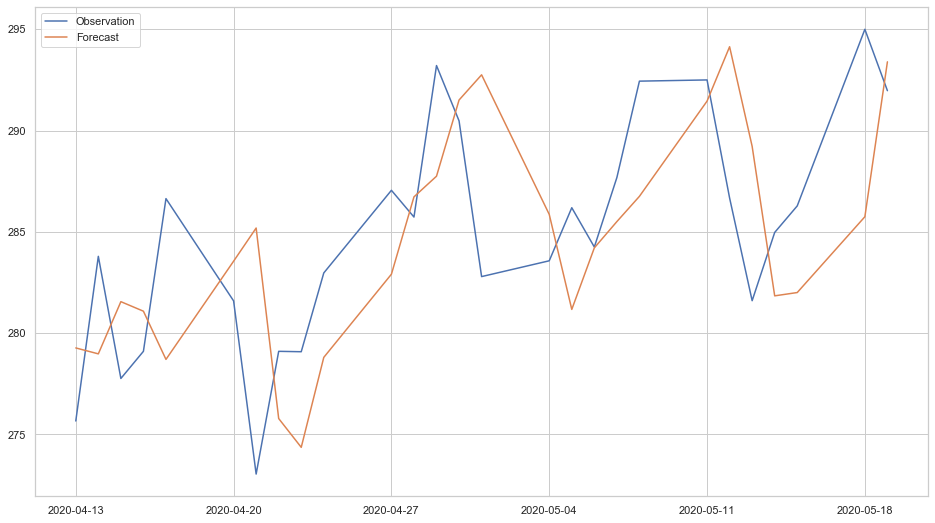

In [84]:
predict_plot('SPY')

In [81]:
def predict_plot2(ticker, val_size=0.9, order=(3,1,0), seasonal_order=(3,1,0,30)):

    data = get_data(ticker)
    size = int(len(data) * val_size)
    train, test = data[:size], data[size:].reset_index(drop=True)
    hist1 = np.asarray(train['Close'])
    hist2 = np.asarray(train[['High', 'Low', 'Open']])
    exog2 = np.asarray(test[['High', 'Low', 'Open']])
    pred = np.zeros(len(test))
    
    for t in range(len(test)):
        model = SARIMAX(endog=hist1, exog=hist2, order=order, seasonal_order=seasonal_order ).fit(disp=0)
        pred[t] = model.forecast(exog=exog2[t])[0]
        hist1 = np.append(hist1, test['Close'][t])
        hist2 = np.concatenate((hist2, exog2[t].reshape(1, 3)))
        
    x = pd.to_datetime(data['Date'])[size:]
    y1 = hist1[size:]
    y2 = pred
    
    plt.figure(figsize=(16,9))
    plt.plot(x, y1)
    plt.plot(x, y2)
    plt.xticks(x[::5])
    plt.legend(['Observation', 'Forecast'])

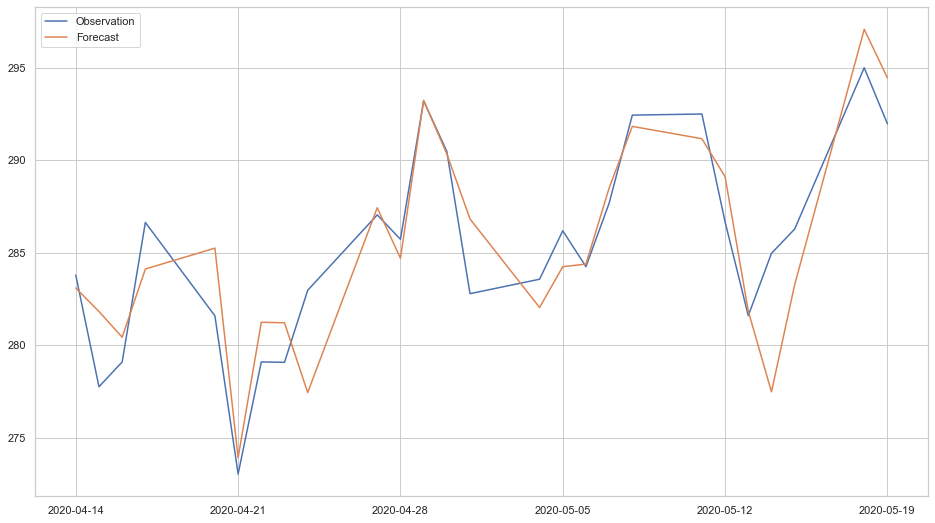

In [82]:
predict_plot2('SPY')

In [85]:
def predict_plot3(ticker, val_size=0.9, order=(3,1,0), seasonal_order=(3,1,0,30)):

    data = get_data(ticker)
    size = int(len(data) * val_size)
    train, test = data[:size], data[size:].reset_index(drop=True)
    hist1 = np.asarray(train['Close'])
    hist2 = np.asarray(train['Open'])
    exog2 = np.asarray(test['Open'])
    pred = np.zeros(len(test))
    
    for t in range(len(test)):
        model = SARIMAX(endog=hist1, exog=hist2, order=order, seasonal_order=seasonal_order ).fit(disp=0)
        pred[t] = model.forecast(exog=exog2[t])[0]
        hist1 = np.append(hist1, test['Close'][t])
        hist2 = np.append(hist2, exog2[t])
        
    x = pd.to_datetime(data['Date'])[size:]
    y1 = hist1[size:]
    y2 = pred
    
    plt.figure(figsize=(16,9))
    plt.plot(x, y1)
    plt.plot(x, y2)
    plt.xticks(x[::5])
    plt.legend(['Observation', 'Forecast'])

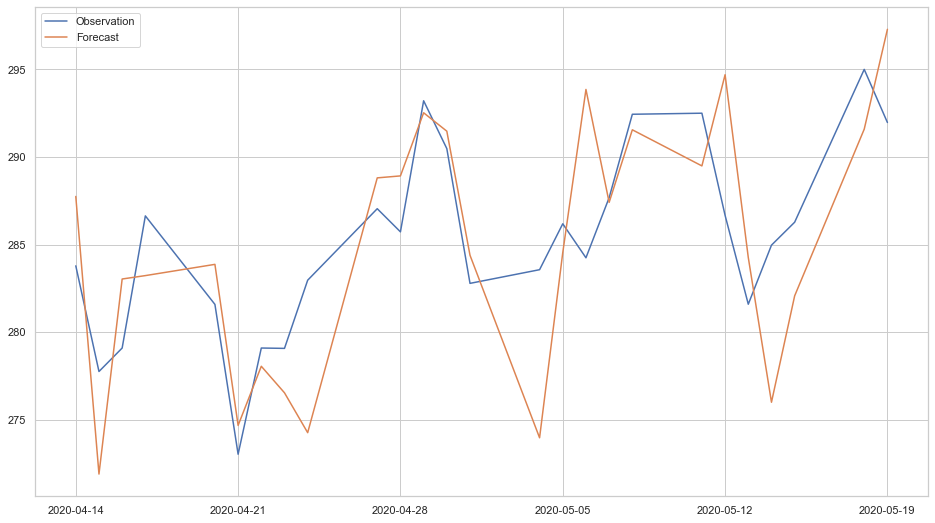

In [86]:
predict_plot3('SPY')

In [ ]:
def decompose_plot(ticker):
    
    fig, ax = plt.subplots(4, 1, figsize=(32,18))
    data = get_data(ticker)
    
    result = seasonal_decompose(data['Close'], model='multiplicative', period=30)

    for i, metric in enumerate([result.observed, result.seasonal, result.trend, result.resid]):
        x = pd.to_datetime(data['Date'])
        y = metric
        ax[i].plot(x, y);

In [ ]:
decompose_plot('SPY')

In [10]:
data = get_data('SPY')
size = int(len(data) * 0.9)
train, test = data[:size], data[size:].reset_index(drop=True)
hist1 = np.asarray(train['Close'])
hist2 = np.asarray(train[['High', 'Low', 'Open']])
exog2 = np.asarray(test[['High', 'Low', 'Open']])
pred = np.zeros(len(test))

In [67]:
get_data('SPY')

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-05-20,285.959991,283.119995,284.059998,283.950012,62877600.0,278.264313
2019-05-21,286.929993,285.549988,285.829987,286.510010,46847100.0,280.773041
2019-05-22,286.690002,285.100006,285.450012,285.630005,49482500.0,279.910645
2019-05-23,283.209991,280.570007,283.160004,282.140015,98733800.0,276.490570
2019-05-24,284.200012,282.089996,283.739990,282.779999,55268100.0,277.117737
...,...,...,...,...,...,...
2020-05-13,287.190002,278.959991,286.059998,281.600006,144721100.0,281.600006
2020-05-14,285.109985,272.989990,278.950012,284.970001,121977900.0,284.970001
2020-05-15,286.329987,281.339996,282.369995,286.279999,111146300.0,286.279999
